In [214]:
from __future__ import print_function
import os
from read_files import split_imdb_files, split_yahoo_files, split_agnews_files
from word_level_process import word_process, get_tokenizer
from char_level_process import char_process
from neural_networks import word_cnn, char_cnn, bd_lstm, lstm
import keras
from keras import backend as K
import tensorflow as tf
import argparse
from config import config
from sklearn.utils import shuffle
from adversarial_tools import ForwardGradWrapper, adversarial_paraphrase
from unbuffered import Unbuffered
import sys
import time
import numpy as np
from config import config
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM, Bidirectional
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D, Flatten, Reshape
from word_level_process import get_tokenizer
from SpectralNormalizationKeras import DenseSN, ConvSN2D
import numpy as np
#import pdb

tf_config = tf.ConfigProto(allow_soft_placement=True)
tf_config.gpu_options.allow_growth = True
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
K.set_session(tf.Session(config=tf_config))

In [237]:
def get_embedding_matrix(dataset, num_words, embedding_dims):
    # global num_words, embedding_matrix, word_index
    global embedding_matrix, word_index
    word_index = get_tokenizer(dataset).word_index
    print('Preparing embedding matrix.')
    # num_words = min(num_words, len(word_index))
    embedding_matrix = np.zeros((num_words + 1, embedding_dims))
    for word, i in word_index.items():
        if i > num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, word_index

def word_cnn(dataset, use_glove=False, sn=True, binary=False):
    filters = 250
    kernel_size = 3
    hidden_dims = 250

    max_len = config.word_max_len[dataset]
    num_classes = config.num_classes[dataset]
    loss = config.loss[dataset]
    activation = config.activation[dataset]
    embedding_dims = config.wordCNN_embedding_dims[dataset]
    num_words = config.num_words[dataset]
#     print(num_words)

    print('Build word_cnn model...')
    model = Sequential()

    if use_glove:
        file_path = r'./glove.6B.{}d.txt'.format(str(embedding_dims))
#         pdb.set_trace()
#         get_embedding_index(file_path)
        embedding_matrix, word_index = get_embedding_matrix(dataset, num_words, embedding_dims)
        model.add(Embedding(  # Layer 0, Start
            input_dim=num_words + 1,  # Size to dictionary, has to be input + 1
            output_dim=embedding_dims,  # Dimensions to generate
            weights=[embedding_matrix],  # Initialize word weights
            input_length=max_len,
            name="embedding_layer",
            trainable=False))
    else:
        # embedding_dims => 50
        word_index = get_tokenizer(dataset).word_index
        model.add(Embedding(num_words, embedding_dims, input_length=max_len))  
    model.add(Dropout(0.2))

    
    if sn:
    ##  with SN  ##
        model.add(Reshape((-1, 400, 50)))
        model.add(ConvSN2D(filters, (1, kernel_size), strides=1, padding='valid', activation='relu'))
        model.add(Reshape((398, 250)))
        model.add(GlobalMaxPooling1D())
        model.add(DenseSN(hidden_dims))
        model.add(Dropout(0.2))
        model.add(Activation('relu'))
        model.add(DenseSN(num_classes))
        model.add(Activation(activation))
    else:
    
    ##  without SN  ##
        model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(hidden_dims))
        model.add(Dropout(0.2))
        model.add(Activation('relu'))
        model.add(Dense(num_classes))
        model.add(Activation(activation))
    

    model.compile(loss=loss,
                  optimizer='adam',
                  metrics=['accuracy'])

    if sn:
        model_path = r'./fool_result/backup/word_cnn.dat_15epoch_sn'
        if binary:
            model_path = r'./runs/imdb/word_cnn.dat_20epoch_binary_sn'
    else:
        model_path = r'./fool_result/backup/word_cnn.dat_15epoch'
        
    #model_path = r'./runs/{}/{}.dat_15epoch_sn'.format(dataset, args.model)
    model.load_weights(model_path)
    return model, model.layers[0].get_weights()

In [216]:
useSN = False
snModel, snEmbs = word_cnn("imdb", use_glove=False, sn=useSN)

Build word_cnn model...


In [217]:
# Word vs All
# Word vs Replacement 
print(type(snEmbs[0]))
print(snEmbs[0].shape)

<class 'numpy.ndarray'>
(5000, 50)


In [218]:
from read_files import read_imdb_files, read_yahoo_files, read_agnews_files
from keras.preprocessing.text import Tokenizer

def get_tokenizer(dataset):
    texts = None
    if dataset == 'imdb':
        texts, _ = read_imdb_files('train')
    elif dataset == 'yahoo':
        texts, _, _ = read_yahoo_files()
    elif dataset == 'agnews':
        texts, _, _ = read_agnews_files('train')
    # first 12500 are postive review, second 12500 are negative review
#     print(config.num_words[dataset])
    tokenizer = Tokenizer(num_words=config.num_words[dataset])
    tokenizer.fit_on_texts(texts)
    return tokenizer

t = get_tokenizer("imdb")

In [219]:
import operator
# Note that 0 is the <unk> token
print(t.texts_to_sequences(["the","and", "a"]))

sorted_d = sorted(t.word_counts.items(), key=operator.itemgetter(1))
topWords = sorted_d[-5000:][::-1]
print(topWords[:3])

wordToDex = {}
for wordDex, wordTup in enumerate(topWords):
    wordToDex[wordTup[0]] = wordDex + 1
    
print(wordToDex["the"])

[[1], [2], [3]]
[('the', 336021), ('and', 164058), ('a', 163002)]
1


In [220]:
import sklearn

embMat = snEmbs[0]
sims = sklearn.metrics.pairwise.cosine_similarity(embMat, embMat, dense_output=True)
simMus = sims.mean()
simStds = sims.std()

In [221]:
print(simMus)
print(simStds)
# import matplotlib.pyplot as plt

# plt.imshow(simMus, cmap='hot', interpolation='nearest')
# plt.show()

0.0023794142
0.1942638


In [230]:
import ast
import json
import re
import scipy

if useSN:
#     fName = "./fool_result/backup/change_tuple_200_15epoch_sn.txt"
    fName = "./fool_result/backup/change_tuple_200_20epoch_binary_sn.txt"
#     fName = "./runs/imdb/word_cnn.dat_20epoch_binary_sn
else:
    fName = "./fool_result/backup/change_tuple_200_15epoch.txt"
    
replaceSims = []
replacePairs = []
with open(fName, 'r') as f:
    lines = f.readlines()
    for lineDex, line in enumerate(lines):
        if lineDex <= 9:
            line = line[1:]
        else:
            line = line[2:]

        searchObj = re.findall( r"\(([0-9]*), '([A-Za-z]*)', SubstitutionCandidate\(token_position=[0-9]*, similarity_rank=[0-9]*, original_token=[A-Za-z]*, candidate_word='([A-Za-z]*)'\), [0-9]*.[0-9]*, '[A-Z]*'\)", line)
        tups = []

        for m in searchObj:
            if m[-1] == ",":
                tups.append(m[:-1])
            else:
                tups.append(m)

        searchObj = re.findall( r"\(([0-9]*), '([A-Za-z]*)', SubstitutionCandidate\(token_position=[0-9]*, similarity_rank=None, original_token=[A-Za-z]*, candidate_word='([A-Za-z]*)'\), [0-9]*.[0-9]*, '[A-Z]*'\)", line)
        for m in searchObj:
            if m[-1] == ",":
                tups.append(m[:-1])
            else:
                tups.append(m)
        
        for tup in tups:
            orgWord = tup[1].lower()
            replace = tup[2].lower()
            replacePairs.append(orgWord + "_" + replace)
            if orgWord in wordToDex and replace in wordToDex:
                orgDex = wordToDex[orgWord]
                repDex = wordToDex[replace]
                sim = scipy.spatial.distance.cosine(embMat[orgDex, :], embMat[repDex, :])
                replaceSims.append(sim)
        
replaceSims = np.array(replaceSims)
print(replaceSims.mean())
print(replaceSims.std())

0.9859629060666278
0.18229644678609241


In [231]:
from wordcloud import WordCloud

wCloudRep = " ".join(replacePairs)
wordcloud = WordCloud().generate(wCloudRep)

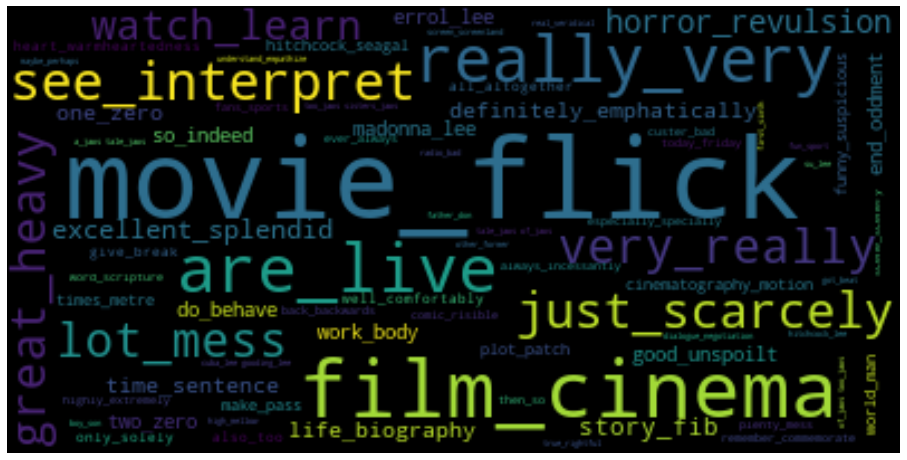

In [234]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [241]:
def getMu_WordCloud(useSN, binary=False):
    snModel, snEmbs = word_cnn("imdb", use_glove=False, sn=useSN, binary=binary)
    t = get_tokenizer("imdb")
    
    sorted_d = sorted(t.word_counts.items(), key=operator.itemgetter(1))
    topWords = sorted_d[-5000:][::-1]

    wordToDex = {}
    for wordDex, wordTup in enumerate(topWords):
        wordToDex[wordTup[0]] = wordDex + 1
        
    if useSN:
        fName = "./fool_result/backup/change_tuple_200_15epoch_sn.txt"
        if binary:
            fName = "./fool_result/backup/change_tuple_200_20epoch_binary_sn.txt"
    else:
        fName = "./fool_result/backup/change_tuple_200_15epoch.txt"

    replaceSims = []
    replacePairs = []
    with open(fName, 'r') as f:
        lines = f.readlines()
        for lineDex, line in enumerate(lines):
            if lineDex <= 9:
                line = line[1:]
            else:
                line = line[2:]

            searchObj = re.findall( r"\(([0-9]*), '([A-Za-z]*)', SubstitutionCandidate\(token_position=[0-9]*, similarity_rank=[0-9]*, original_token=[A-Za-z]*, candidate_word='([A-Za-z]*)'\), [0-9]*.[0-9]*, '[A-Z]*'\)", line)
            tups = []

            for m in searchObj:
                if m[-1] == ",":
                    tups.append(m[:-1])
                else:
                    tups.append(m)

            searchObj = re.findall( r"\(([0-9]*), '([A-Za-z]*)', SubstitutionCandidate\(token_position=[0-9]*, similarity_rank=None, original_token=[A-Za-z]*, candidate_word='([A-Za-z]*)'\), [0-9]*.[0-9]*, '[A-Z]*'\)", line)
            for m in searchObj:
                if m[-1] == ",":
                    tups.append(m[:-1])
                else:
                    tups.append(m)

            for tup in tups:
                orgWord = tup[1].lower()
                replace = tup[2].lower()
                replacePairs.append(orgWord + "_" + replace)
                if orgWord in wordToDex and replace in wordToDex:
                    orgDex = wordToDex[orgWord]
                    repDex = wordToDex[replace]
                    sim = scipy.spatial.distance.cosine(embMat[orgDex, :], embMat[repDex, :])
                    replaceSims.append(sim)

    replaceSims = np.array(replaceSims)
    mu = replaceSims.mean()
    std = replaceSims.std()
    
    wCloudRep = " ".join(replacePairs)
    wordcloud = WordCloud().generate(wCloudRep)
    
    return mu, std, wordcloud

In [242]:
regMu, regStd, regWord = getMu_WordCloud(useSN=False, binary=False)
snMu, snStd, snWord = getMu_WordCloud(useSN=True, binary=False)
binMu, binStd, binWord = getMu_WordCloud(useSN=True, binary=True)

Build word_cnn model...
Build word_cnn model...
Build word_cnn model...


In [243]:
print("Reg Mu: {} SN Mu: {} Bin Mu: {}".format(regMu, snMu, binMu))

Reg Mu: 0.9859629060666278 SN Mu: 0.9966076390214703 Bin Mu: 1.000000335321767


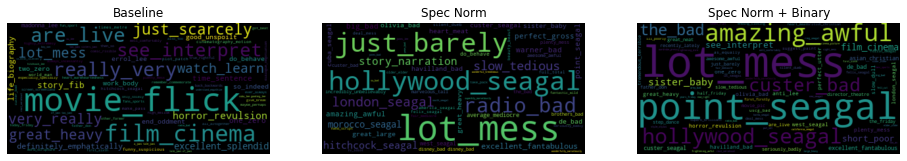

In [266]:
fig, axs = plt.subplots(1, 3, figsize=(16,8))
axs[0].imshow(regWord, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title("Baseline")
axs[1].imshow(snWord, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title("Spec Norm")
axs[2].imshow(binWord, interpolation='bilinear')
axs[2].axis('off')
axs[2].set_title("Spec Norm + Binary")
plt.show()